# CLIP コサイン類似度サンプリング可視化（Torch実装）

このノートブックは、DreamerV3環境から画像をサンプリングし、OpenCLIPを用いてテキストまたは画像クエリに対するコサイン類似度でランク付けします。

手順:
1. 設定名を選択（デフォルト: atari100k）。
2. 環境から画像をサンプリング。
3. CLIPで画像をエンコード。
4. テキストまたは画像クエリでランク付けし、上位/下位の結果を表示。


In [1]:
from __future__ import annotations

import math

import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
import elements
import open_clip
from tqdm import tqdm

import dreamerv3.main as d3main


def load_config(config_name: str):
    """Load DreamerV3 config by name.

    Args:
      config_name: Config name in dreamerv3/configs.yaml.

    Returns:
      elements.Config merged with defaults.
    """
    config_path = elements.Path("/home/ist_baidoku/yoshinari.kawashima/wm25_final_homework/dreamerv3/dreamerv3/configs.yaml")
    configs = yaml.YAML(typ="safe").load(config_path.read())
    config = elements.Config(configs["defaults"])
    config = config.update(configs[config_name])
    return config


def to_pil_image(image):
    """Convert input image array to RGB PIL image.

    Args:
      image: Numpy array or PIL.Image.

    Returns:
      PIL.Image in RGB mode.
    """
    if isinstance(image, Image.Image):
        return image.convert("RGB")
    array = np.asarray(image)
    if array.ndim == 2:
        array = np.repeat(array[:, :, None], 3, axis=-1)
    if array.shape[-1] == 1:
        array = np.repeat(array, 3, axis=-1)
    if array.dtype != np.uint8:
        array = np.clip(array, 0, 255).astype(np.uint8)
    return Image.fromarray(array)


def sample_env_images(env, num_images, image_key="image", seed=0):
    """Sample images by stepping the env with random actions.

    Args:
      env: embodied.Env instance.
      num_images: Number of images to collect.
      image_key: Observation key that contains the image.
      seed: RNG seed for numpy.

    Returns:
      List of numpy arrays.
    """
    np.random.seed(seed)
    images = []
    action = {k: v.sample() for k, v in env.act_space.items() if k != "reset"}
    action["reset"] = True
    obs = env.step(action)
    images.append(obs[image_key])
    while len(images) < num_images:
        action = {k: v.sample() for k, v in env.act_space.items() if k != "reset"}
        action["reset"] = bool(obs.get("is_last", False))
        obs = env.step(action)
        images.append(obs[image_key])
    return images


import math
import numpy as np
import matplotlib.pyplot as plt

# to_pil_image が torchvision 等からインポートされている前提とします
# from torchvision.transforms.functional import to_pil_image


def plot_image_grid(images, scores=None, title=None, max_cols=8):
    """Plot images in a grid with index numbers and optional scores.

    Args:
      images: List of images (numpy arrays).
      scores: Optional list/array of scores aligned with images.
      title: Optional figure title.
      max_cols: Max columns in grid.

    Returns:
      None.
    """
    if not images:
        print("No images to display.")
        return
    count = len(images)
    cols = min(count, max_cols)
    rows = math.ceil(count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))

    # axesが1つの場合や1次元の場合でも一貫して扱えるように整形
    if count == 1:
        axes = np.array([axes])
    axes = np.array(axes).reshape(rows, cols)

    for idx in range(rows * cols):
        ax = axes.flat[idx]
        ax.axis("off")
        if idx >= count:
            continue

        # 画像の表示
        img = to_pil_image(images[idx])
        ax.imshow(img)

        # --- タイトル設定の変更箇所 ---
        # インデックス番号を基本のタイトルとする
        label = f"idx: {idx}"

        # スコアがある場合は改行して追記（または横に並べる）
        if scores is not None:
            label += f"\n{scores[idx]:.3f}"

        ax.set_title(label, fontsize=8)
        # ---------------------------

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def build_clip(model_name="ViT-B-32", pretrained="laion2b_s34b_b79k", device=None):
    """Create OpenCLIP model and preprocessing.

    Args:
      model_name: CLIP model name.
      pretrained: Pretrained weights name.
      device: torch.device or None.

    Returns:
      Tuple of (model, preprocess, tokenizer, device).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
    model.eval()
    model.to(device)
    if device.type == "cuda":
        model.half()
    tokenizer = open_clip.get_tokenizer(model_name)
    return model, preprocess, tokenizer, device


def normalize_features(features, eps=1e-6):
    """L2-normalize feature vectors.

    Args:
      features: Torch tensor of shape (N, D).
      eps: Small epsilon to avoid divide-by-zero.

    Returns:
      Normalized tensor.
    """
    return features / (features.norm(dim=-1, keepdim=True) + eps)


def encode_images(model, preprocess, images, device, batch_size=16):
    """Encode images into CLIP embeddings.

    Args:
      model: CLIP model.
      preprocess: Preprocess function from OpenCLIP.
      images: List of images (numpy arrays or PIL).
      device: torch.device.
      batch_size: Batch size.

    Returns:
      Torch tensor of shape (N, D) on device.
    """
    batches = []
    # ここにtqdmを追加しました
    for start in tqdm(range(0, len(images), batch_size)):
        batch_images = [preprocess(to_pil_image(img)) for img in images[start : start + batch_size]]
        batch = torch.stack(batch_images).to(device)
        with torch.inference_mode():
            if device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    feats = model.encode_image(batch)
            else:
                feats = model.encode_image(batch)
        feats = normalize_features(feats)
        batches.append(feats)
    return torch.cat(batches, dim=0)


def encode_texts(model, tokenizer, texts, device):
    """Encode texts into CLIP embeddings.

    Args:
      model: CLIP model.
      tokenizer: OpenCLIP tokenizer.
      texts: List of text strings.
      device: torch.device.

    Returns:
      Torch tensor of shape (N, D) on device.

    Raises:
      ValueError: If texts is empty.
    """
    if not texts:
        raise ValueError("texts must be a non-empty list.")
    tokens = tokenizer(texts).to(device)
    with torch.inference_mode():
        if device.type == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                feats = model.encode_text(tokens)
        else:
            feats = model.encode_text(tokens)
    return normalize_features(feats)


def cosine_scores(image_embs, query_emb):
    """Compute cosine similarity scores between images and a query.

    Args:
      image_embs: Tensor of shape (N, D), normalized.
      query_emb: Tensor of shape (D,) or (1, D), normalized.

    Returns:
      Numpy array of shape (N,).
    """
    if query_emb.ndim == 1:
        query_emb = query_emb[None, :]
    scores = (image_embs @ query_emb.T).squeeze(-1)
    return scores.detach().cpu().numpy()


def rank_indices(scores, exclude_indices=None):
    """Rank indices by score ascending.

    Args:
      scores: Score array.
      exclude_indices: Optional iterable of indices to exclude.

    Returns:
      Numpy array of indices sorted ascending by score.
    """
    scores = np.asarray(scores)
    indices = np.arange(scores.size)
    if exclude_indices:
        exclude = np.array(list(exclude_indices), dtype=int)
        mask = np.ones(scores.size, dtype=bool)
        mask[exclude] = False
        indices = indices[mask]
        scores = scores[mask]
    order = indices[np.argsort(scores)]
    return order


def select_top_bottom(scores, top_k, bottom_k, exclude_indices=None):
    """Select top and bottom indices from scores.

    Args:
      scores: Score array.
      top_k: Number of top items.
      bottom_k: Number of bottom items.
      exclude_indices: Optional iterable of indices to exclude.

    Returns:
      Tuple of (top_indices, bottom_indices).
    """
    order = rank_indices(scores, exclude_indices=exclude_indices)
    top_indices = order[::-1][:top_k] if top_k else np.array([], dtype=int)
    bottom_indices = order[:bottom_k] if bottom_k else np.array([], dtype=int)
    return top_indices.tolist(), bottom_indices.tolist()


def show_ranked(images, scores, top_k=8, bottom_k=8, title="", exclude_indices=None):
    """Display top and bottom ranked images.

    Args:
      images: List of images.
      scores: Score array aligned with images.
      top_k: Number of top images to show.
      bottom_k: Number of bottom images to show.
      title: Optional label printed before plots.
      exclude_indices: Optional iterable of indices to exclude from ranking.

    Returns:
      None.
    """
    if title:
        print(title)
    top_indices, bottom_indices = select_top_bottom(scores, top_k, bottom_k, exclude_indices=exclude_indices)
    if top_indices:
        plot_image_grid(
            [images[i] for i in top_indices], scores=[scores[i] for i in top_indices], title=f"Top {len(top_indices)}"
        )
    if bottom_indices:
        plot_image_grid(
            [images[i] for i in bottom_indices],
            scores=[scores[i] for i in bottom_indices],
            title=f"Bottom {len(bottom_indices)}",
        )

/home/ist_baidoku/yoshinari.kawashima/wm25_final_homework/dreamerv3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_name = "atari100k"  # or "dmc_vision"
image_key = "image"

num_samples = 1000
seed = 0

config = load_config(config_name)
config = config.update({"task": "atari100k_freeway"})
env = d3main.make_env(config, 0)
images = sample_env_images(env, num_samples, image_key=image_key, seed=seed)
if hasattr(env, "close"):
    env.close()
print(f"Collected {len(images)} images from {config_name}.")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Collected 1000 images from atari100k.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
torch.cuda.is_available()

True

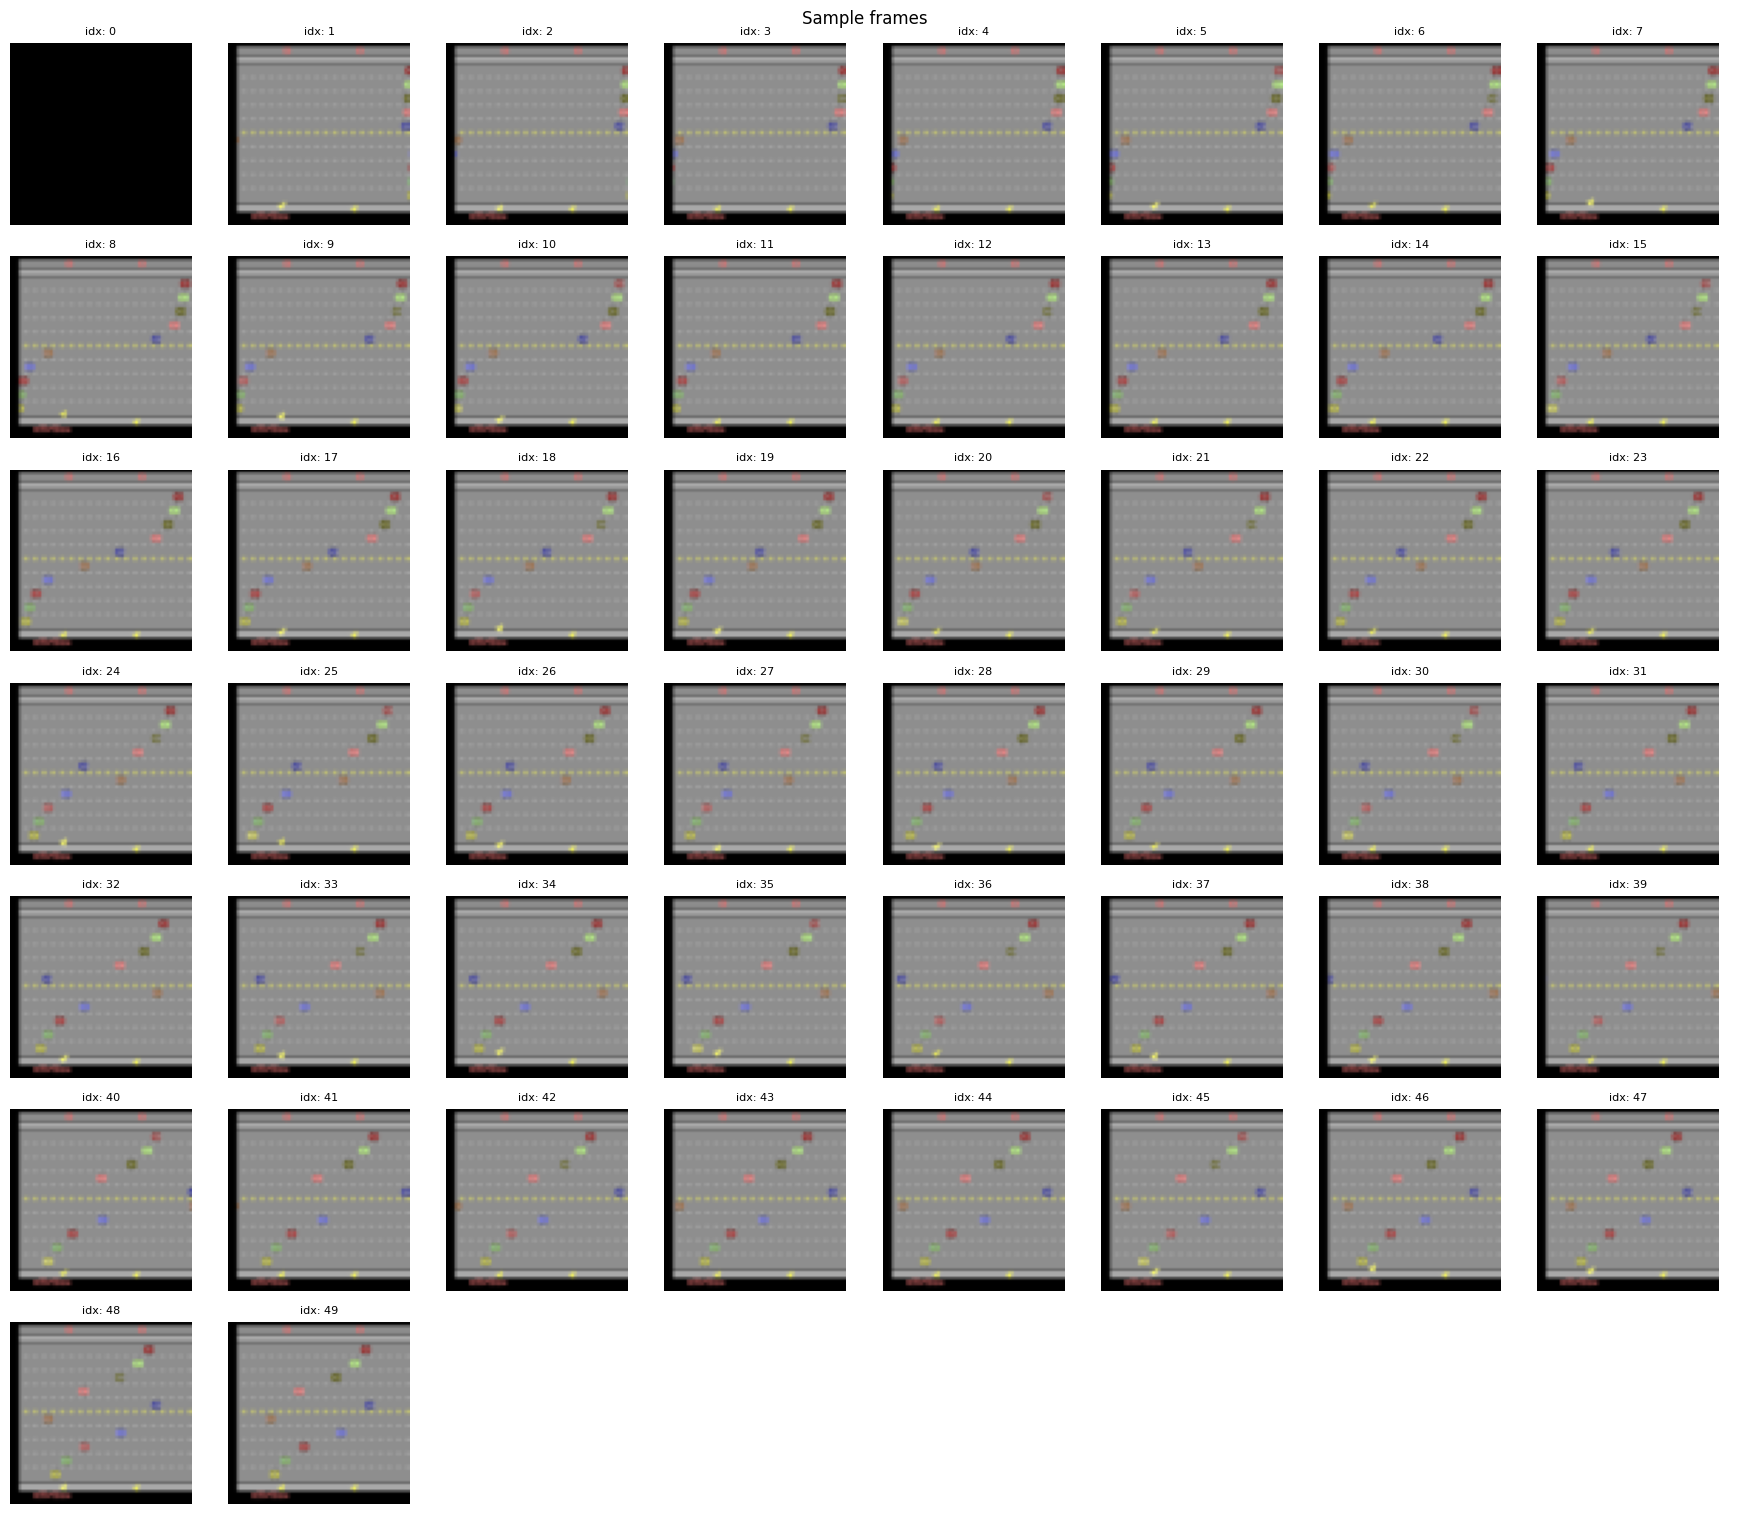

In [4]:
plot_image_grid(images[:50], title="Sample frames")

In [5]:
model_name = "ViT-B-32"
pretrained = "laion2b_s34b_b79k"
batch_size = 16

model, preprocess, tokenizer, device = build_clip(model_name=model_name, pretrained=pretrained)
print(f"Using device: {device}")

/home/ist_baidoku/yoshinari.kawashima/wm25_final_homework/dreamerv3/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:423: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


Using device: cuda


In [6]:
image_embs = encode_images(model, preprocess, images, device, batch_size=batch_size)
print(f"Image embeddings: {tuple(image_embs.shape)}")

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:01<00:00, 39.71it/s]

Image embeddings: (1000, 512)


In [7]:
import torch, sys

print("python:", sys.executable)
print("torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("is_available:", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())

python: /home/ist_baidoku/yoshinari.kawashima/wm25_final_homework/dreamerv3/.venv/bin/python
torch: 2.11.0.dev20251219+cu128
torch.version.cuda: 12.8
is_available: True
device_count: 1


Text query: "A yellow circle in the center. Colorful random objects nearby."


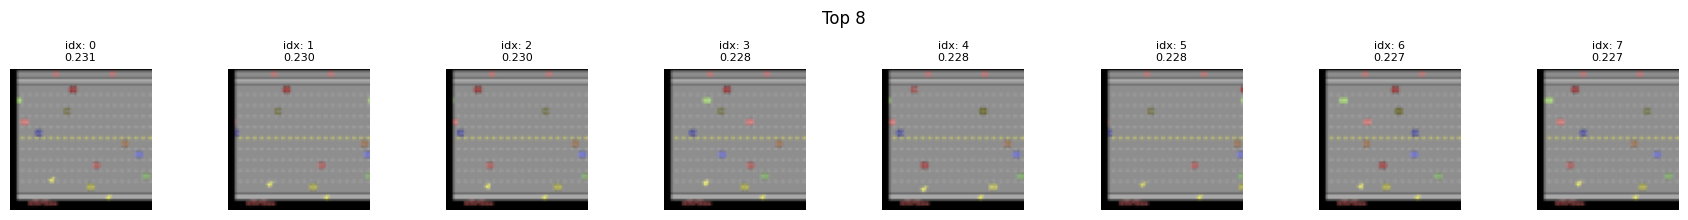

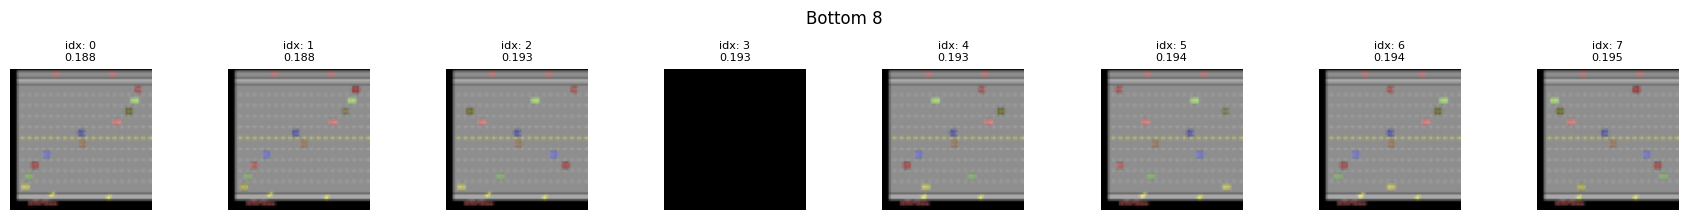

In [8]:
text_queries = [
    "A yellow circle in the center. Colorful random objects nearby.",
    "a pong game",
    "a simple colorful scene",
    "a close-up of a character",
]
query_index = 0
top_k = 8
bottom_k = 8

text_embs = encode_texts(model, tokenizer, text_queries, device)
query_emb = text_embs[query_index]
scores = cosine_scores(image_embs, query_emb)
show_ranked(
    images,
    scores,
    top_k=top_k,
    bottom_k=bottom_k,
    title=f'Text query: "{text_queries[query_index]}"',
)

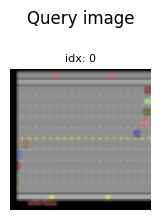

100%|██████████| 1/1 [00:00<00:00, 28.29it/s]

Image query


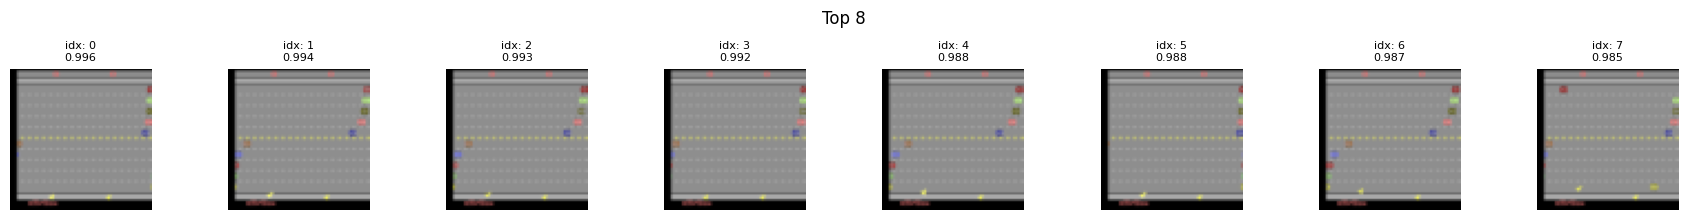

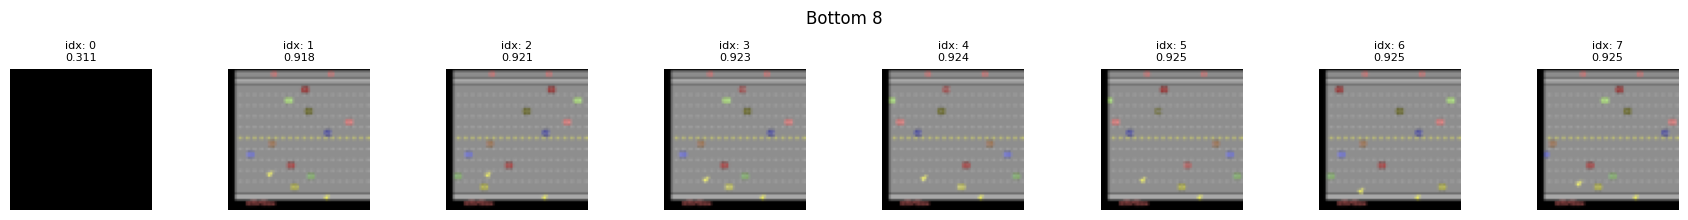

In [9]:
image_query_mode = "sample"  # "sample" or "file"
query_index = 4
query_path = "path/to/query.png"
exclude_query_from_ranking = True

if image_query_mode == "file":
    query_image = Image.open(query_path)
else:
    query_image = images[query_index]

plot_image_grid([query_image], title="Query image")

query_emb = encode_images(model, preprocess, [query_image], device, batch_size=1)[0]
scores = cosine_scores(image_embs, query_emb)
exclude = [query_index] if (image_query_mode == "sample" and exclude_query_from_ranking) else None
show_ranked(
    images,
    scores,
    top_k=top_k,
    bottom_k=bottom_k,
    title="Image query",
    exclude_indices=exclude,
)

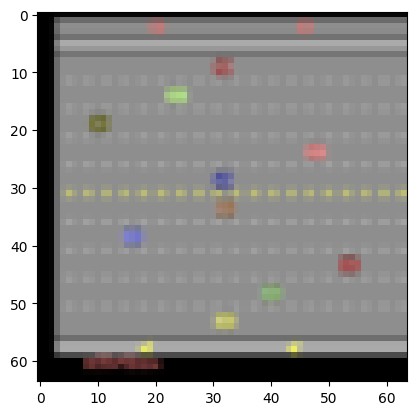

In [10]:
plt.imshow(images[100])